In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas_profiling as pdp
import lightgbm as lgb
import featuretools as ft
import math

In [2]:
path = os.getcwd()
print(path)

/workspace/code


In [3]:
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [4]:
df_train = pd.read_csv('/workspace/data/train.csv')
df_test =pd.read_csv('/workspace/data/test.csv')

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [7]:
pdp.ProfileReport(df_train)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### 特徴量の説明  
Pclass:Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd  
sibsp: 兄弟姉妹＝兄、姉、義理の兄、義理の姉 配偶者＝夫、妻（愛人、婚約者は無視された)の数  
parch: 親＝母，父 子＝娘、息子、継娘、継息子の数 
※子守りと一緒に旅行しただけの子供もいるので、その場合はparch=0  
embarked: 出港港 C = Cherbourg, Q = Queenstown, S = Southampton

In [14]:
df_train_1_corr = df_train[['Fare','Parch','SibSp','Pclass','Survived']].corr()

In [15]:
mask = np.triu(np.ones_like(df_train_1_corr, dtype=bool))

<AxesSubplot:>

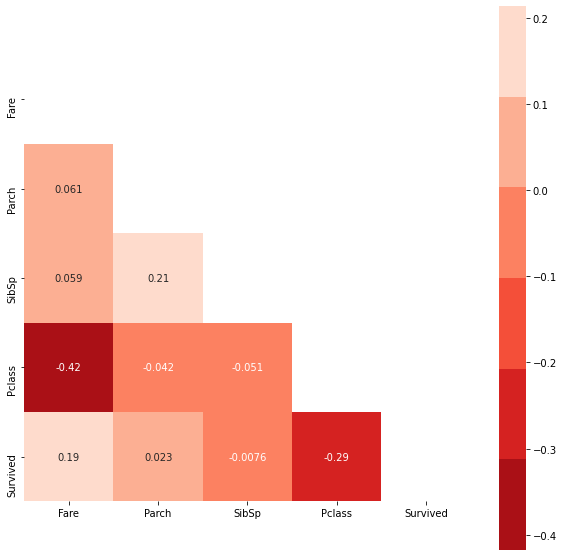

In [17]:
plt.figure(figsize=(10,10))
cmap = sns.color_palette("Reds_r")
sns.heatmap(df_train_1_corr, square=True, annot=True, mask=mask, cmap=cmap)

In [18]:
from autoviz.AutoViz_Class import AutoViz_Class

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.


Shape of your Data Set: (100000, 12)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  2
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  2
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    12 Predictors classified...
        This does not include the Target column(s)
        3 variables removed since they were ID or low-information variables
Number of All Scatter Plots = 3


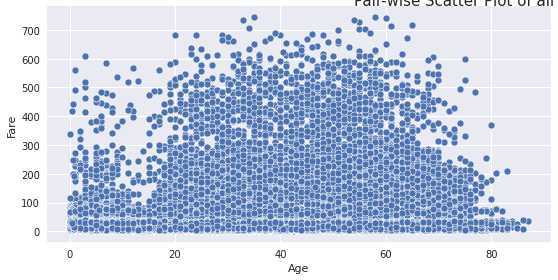

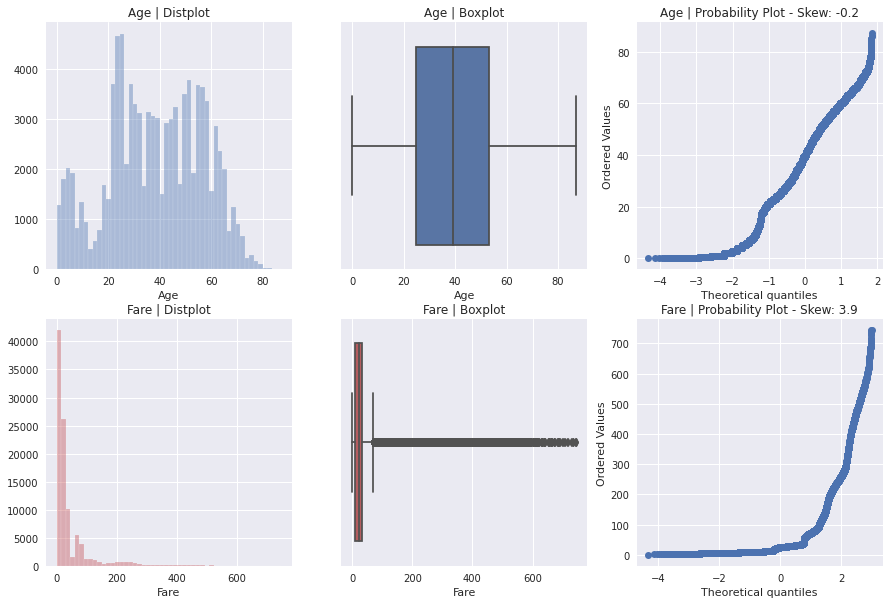

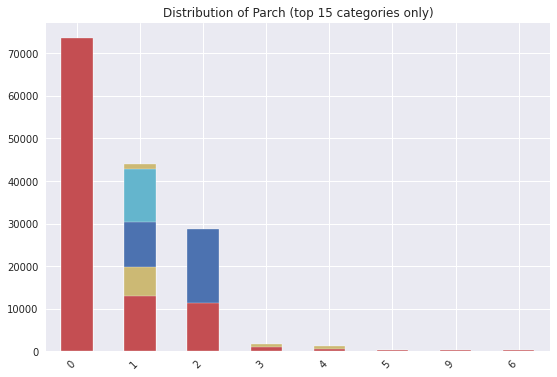

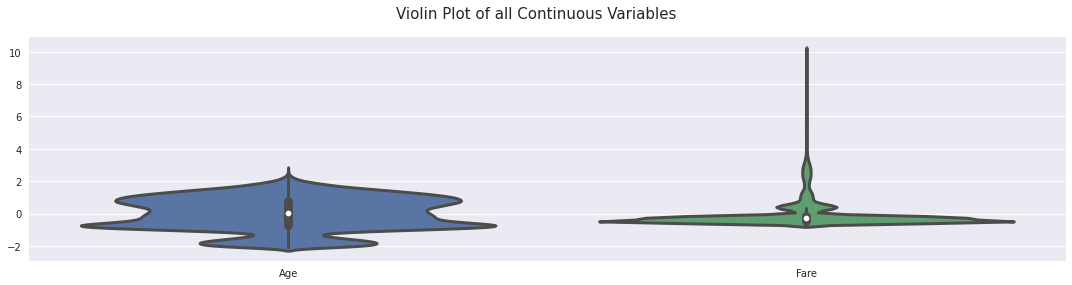

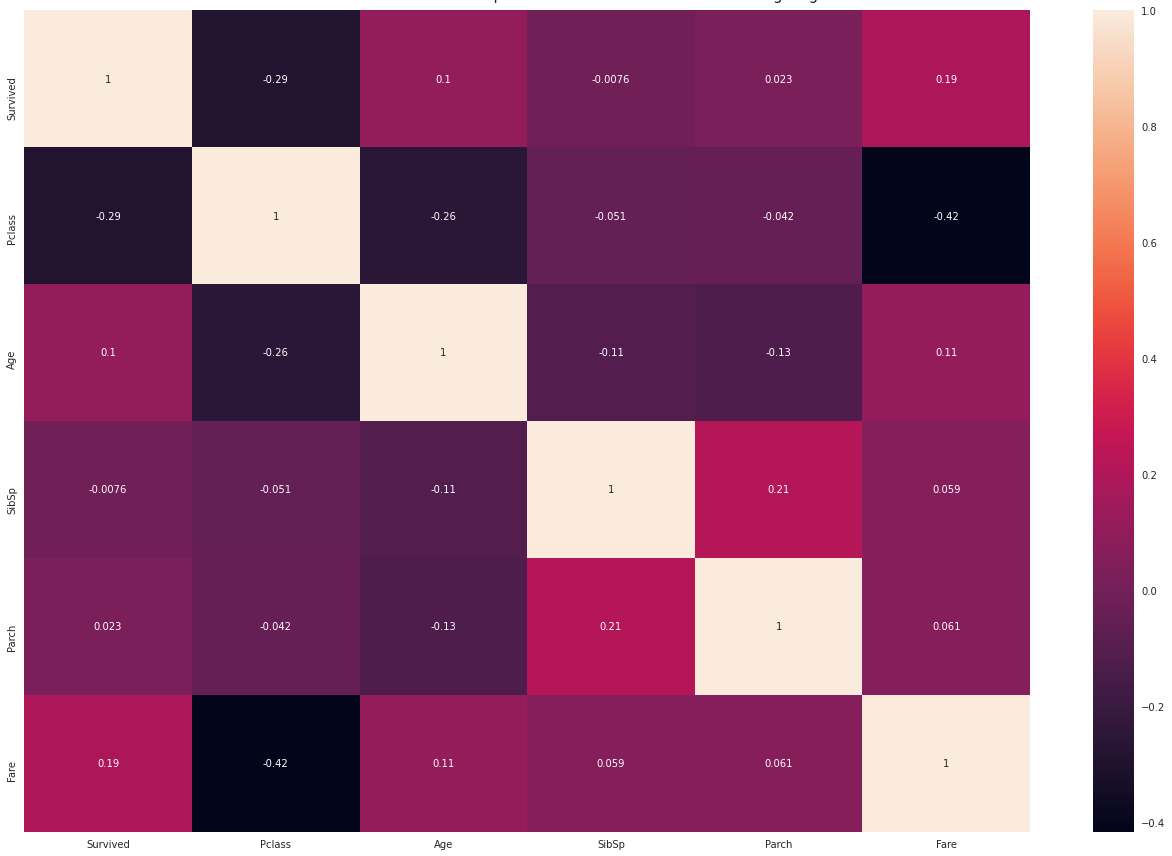

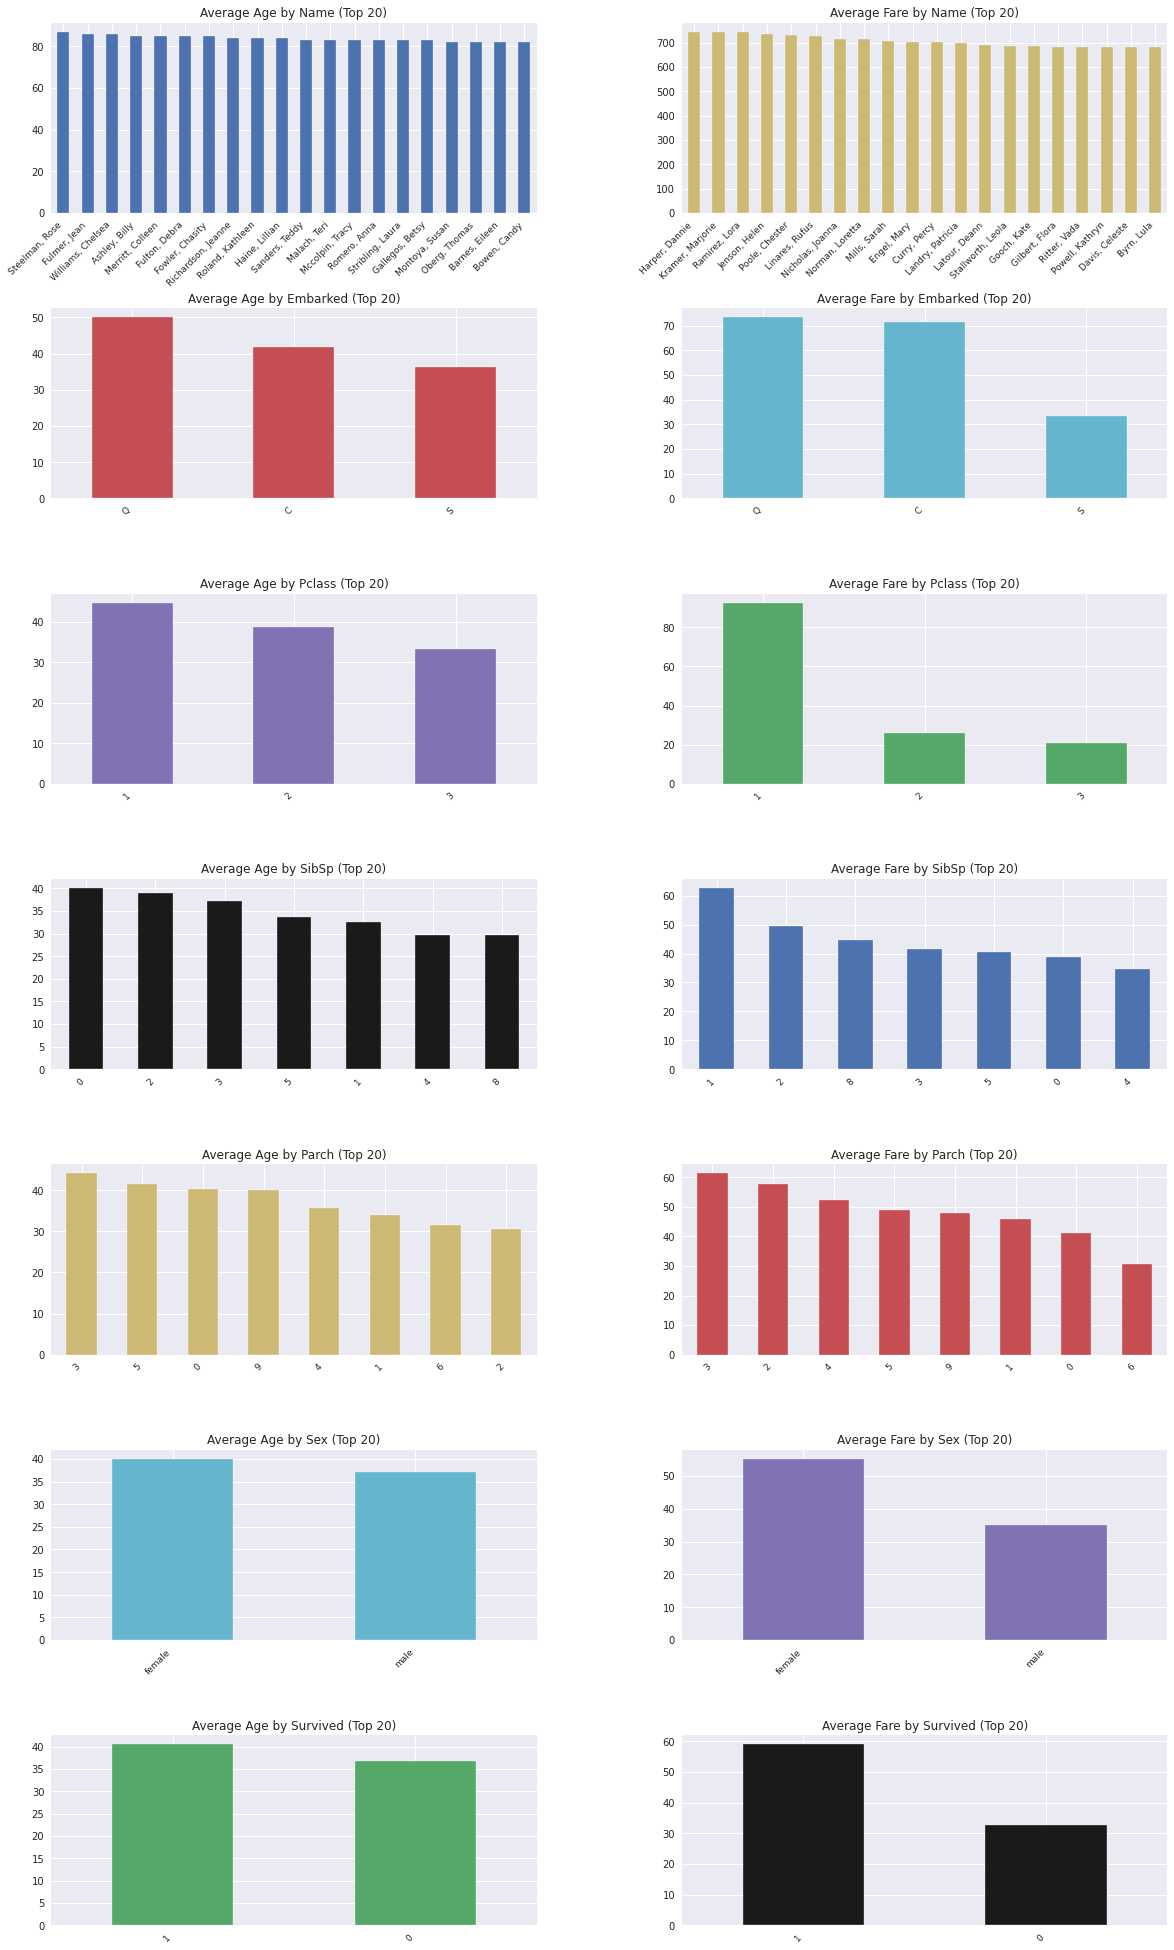

Time to run AutoViz (in seconds) = 3.926

 ###################### VISUALIZATION Completed ########################


In [19]:
autoviz = AutoViz_Class().AutoViz('/workspace/data/train.csv')

## EDA  
性別毎の生存率を見ていく

In [32]:
#男性の生存率
print('男性の総数:{}人'.format(len(df_train[(df_train['Sex']=='male')])))
print('男性の生存者数:{}人'.format(len(df_train[(df_train['Sex']=='male') & (df_train['Survived']==1)])))
print('男性の生存率{:.2%}'.format((len(df_train[(df_train['Sex']=='male') & (df_train['Survived']==1)]))/len(df_train[(df_train['Sex']=='male')])))

男性の総数:56114人
男性の生存者数:11548人
男性の生存率20.58%


In [33]:
#女性の生存率
print('女性の総数:{}人'.format(len(df_train[(df_train['Sex']=='female')])))
print('女性の生存者数:{}人'.format(len(df_train[(df_train['Sex']=='female') & (df_train['Survived']==1)])))
print('女性の生存率{:.2%}'.format((len(df_train[(df_train['Sex']=='female') & (df_train['Survived']==1)]))/len(df_train[(df_train['Sex']=='female')])))

女性の総数:43886人
女性の生存者数:31226人
女性の生存率71.15%


In [42]:
male_survived = len(df_train[(df_train['Sex']=='male') & (df_train['Survived']==1)])/len(df_train[(df_train['Sex']=='male')])
female_survived = len(df_train[(df_train['Sex']=='female') & (df_train['Survived']==1)])/len(df_train[(df_train['Sex']=='female')])

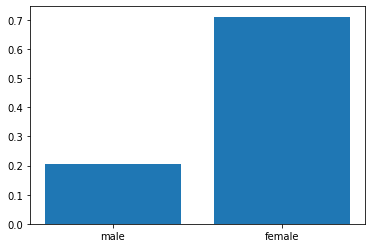

In [58]:
# 生存率を比較
left = ['male', 'female']  # グラフの横軸（X軸）
height = [male_survived, female_survived]  # 値（Y軸）
plt.bar(left, height)
plt.show()

### Pclass(チケットの種類)別の生存率を確認

In [69]:
#欠損値の確認
df_train['Pclass'].isnull().sum()

0

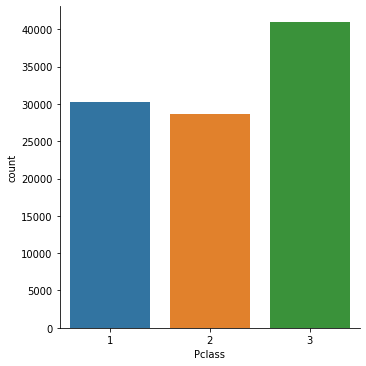

In [67]:
# チケット別の乗客数
sns.catplot(x="Pclass", data=df_train, kind="count")

チケット3の人が多い

In [65]:
print('Class1の生存率{:.2%}'.format((len(df_train[(df_train['Pclass']==1) & (df_train['Survived']==1)]))/len(df_train[(df_train['Pclass']==1)])))
print('Class2の生存率{:.2%}'.format((len(df_train[(df_train['Pclass']==2) & (df_train['Survived']==1)]))/len(df_train[(df_train['Pclass']==2)])))
print('Class3の生存率{:.2%}'.format((len(df_train[(df_train['Pclass']==3) & (df_train['Survived']==1)]))/len(df_train[(df_train['Pclass']==3)])))

Class1の生存率57.98%
Class2の生存率52.50%
Class3の生存率24.73%


In [129]:
Class1_survived = len(df_train[(df_train['Pclass']==1) & (df_train['Survived']==1)]) / len(df_train[(df_train['Pclass']==1)])
Class2_survived = len(df_train[(df_train['Pclass']==2) & (df_train['Survived']==1)]) / len(df_train[(df_train['Pclass']==2)])
Class3_survived = len(df_train[(df_train['Pclass']==3) & (df_train['Survived']==1)]) / len(df_train[(df_train['Pclass']==2)])

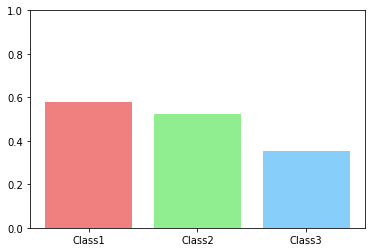

In [131]:
# 生存率を比較
left = ['Class1', 'Class2','Class3']  # グラフの横軸（X軸）
height = [Class1_survived,Class2_survived ,Class3_survived]  # 値（Y軸）
plt.bar(left, height,color=['lightcoral','lightgreen','lightskyblue'])
plt.ylim(0,1)
plt.show()

良いチケットの人が優先的に救助されたことがわかる

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

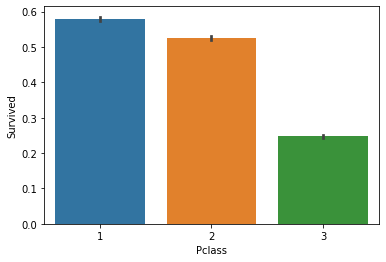

In [241]:
#平均値をy軸で表現にする
sns.barplot(x='Pclass',y='Survived',data=df_train)

In [240]:
df_train[(df_train['Parch']==0)].mean()

PassengerId    50001.786443
Survived           0.405208
Pclass             2.130514
Age               40.250072
SibSp              0.246410
Parch              0.000000
Fare              41.173608
dtype: float64

In [244]:
df_train[(df_train['Pclass']==3)].mean()

PassengerId    49983.233722
Survived           0.247305
Pclass             3.000000
Age               33.407362
SibSp              0.357801
Parch              0.419622
Fare              20.618226
dtype: float64

### 年齢別の生存率を確認

In [76]:
#欠損値確認 3292がNan
df_train['Age'].isnull().sum()

3292

<AxesSubplot:xlabel='Age', ylabel='Count'>

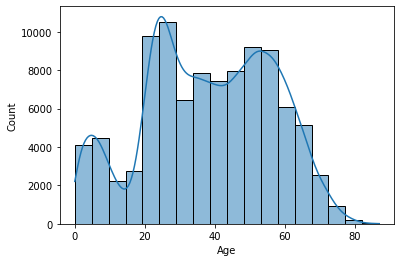

In [97]:
#年齢毎の乗客数を確認
sns.histplot(df_train['Age'],kde=True,bins=18)

In [90]:
#スタージェスの公式
sturges = lambda n: math.ceil(math.log2(n*2))

In [96]:
#最適なbinsの値を求める
print(sturges(len(df_train['Age'])))
print(sturges(len(df_train['Age'][df_train['Survived']==1])))
print(sturges(len(df_train['Age'][df_train['Survived']==0])))

18
17
17


<AxesSubplot:xlabel='Age', ylabel='Count'>

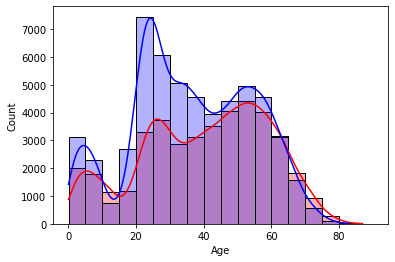

In [135]:
#若い年代の死者が多く　高齢者はかなり生存している
sns.histplot(df_train['Age'][df_train['Survived'] ==1],kde=True, color='red', bins=17,binwidth=5, alpha=0.3 )
sns.histplot(df_train['Age'][df_train['Survived'] ==0],kde=True, color='blue', bins=17,binwidth=5, alpha=0.3)

In [ ]:
##

In [136]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### 特徴量の説明(再掲)  
特徴量の種類  
・PassengerId : 乗客のID  
・Survived : 生死(0:死亡,1:生存)  
・Pclass : 乗客の社会階級(1:Upper, 2:Middle, 3:Lower) チケットクラス  
・Name : 名前  
・Sex : 性別  
・Age : 年齢  
・SibSp : 一緒に乗っている兄弟、配偶者の数(愛人、婚約者は無視)  
・Parch : 一緒に乗っている親、子供の数(※子守りと一緒に旅行しただけの子供もいるので、その場合はparch=0)  
・Ticket : チケットの番号  
・Fare : 乗船料  
・Cabin : 客室番号  
・Embarked : 乗船した港  

In [162]:
#SibSpとParchの値の値を確認
print(np.sort(df_train['SibSp'].unique()))
print(np.sort(df_train['Parch'].unique()))

[0 1 2 3 4 5 8]
[0 1 2 3 4 5 6 9]


In [176]:
#Sibspの生存率確認
SibSp_list = [] 
for i in np.sort(df_train['SibSp'].unique()):
    SibSp_list.append(len(df_train[(df_train['SibSp']==i) & (df_train['Survived']==1)]) / len(df_train[(df_train['SibSp']==i)]))

In [177]:
Parch_list = [] 
for i in np.sort(df_train['Parch'].unique()):
    Parch_list.append(len(df_train[(df_train['Parch']==i) & (df_train['Survived']==1)]) / len(df_train[(df_train['Parch']==i)]))

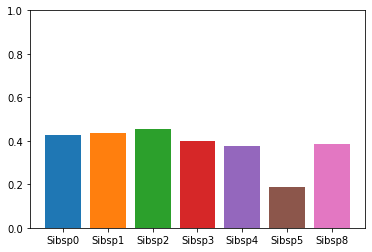

In [206]:
# Sibspの生存率を比較
cmap = plt.get_cmap("tab10")
left = ['Sibsp0', 'Sibsp1','Sibsp2','Sibsp3','Sibsp4','Sibsp5','Sibsp8']  # グラフの横軸（X軸）
height = SibSp_list  # 値（Y軸）
plt.bar(left, height,color=[cmap(0),cmap(1),cmap(2),cmap(3),cmap(4),cmap(5),cmap(6)])
plt.ylim(0,1)
plt.show()

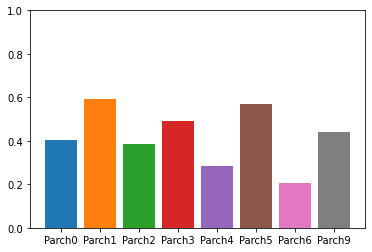

In [208]:
# Parchの生存率を比較
cmap = plt.get_cmap("tab10")
left = ['Parch0', 'Parch1','Parch2','Parch3','Parch4','Parch5','Parch6','Parch9']  # グラフの横軸（X軸）
height = Parch_list  # 値（Y軸）
plt.bar(left, height,color=[cmap(0),cmap(1),cmap(2),cmap(3),cmap(4),cmap(5),cmap(6),cmap(7),cmap(8)])
plt.ylim(0,1)
plt.show()

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

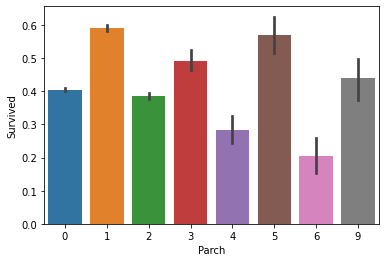

In [231]:
#平均値をy軸で表現にする
sns.barplot(x='Parch',y='Survived',data=df_train)